# Algoritmo de Metropolis–Hastings
## Danilo Lemos Cardoso

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

O objetivo é estimar a distribuição a posteriori da correlação de
duas variáveis com distribuição normal padrão usando o algoritmo de Metropolis–Hastings. 

Para isso vamos definir um valor de correlação $\rho$ e gerar uma amostra com $N$ elementos da
distribuição normal bivariável:

$(X, Y) \sim \mathcal{N}(\mu; \Sigma)$

onde $\mu = (\mu_X,\mu_Y)$ e $\Sigma =
\begin{equation*}
\mathbf{}\left[\begin{matrix}
\sigma^2_X & \rho \sigma_X \sigma_Y\\
\rho \sigma_X \sigma_Y & \sigma^2_Y
\end{matrix}\right] 
\end{equation*}
$.

No nosso caso: 
$(X, Y) \sim \mathcal{N}\left((0,0); \begin{equation*}
\mathbf{}\left[\begin{matrix}
1 & \rho\\
\rho & 1
\end{matrix}\right] 
\end{equation*}\right)$.


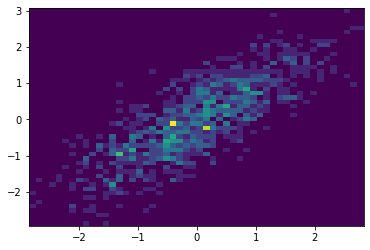

In [2]:
rho = 0.8
N = 1000

Z = np.random.multivariate_normal([0,0], [[1, rho], [rho, 1]], N).T
X = Z[0]
Y = Z[1]

plt.hist2d(X, Y, bins=50);

Apesar de serem dependentes, as variáveis têm distribuição $\mathcal{N}(0;1)$

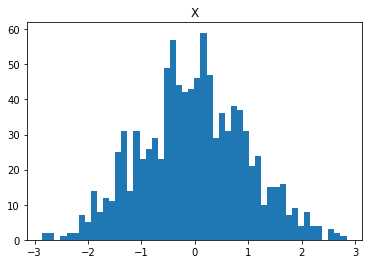

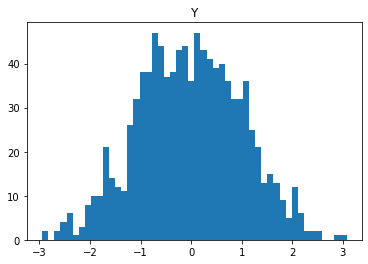

In [3]:
plt.hist(X, bins=50)
plt.title("X")
plt.show()

plt.hist(Y, bins=50)
plt.title("Y")
plt.show()

Com esses valores a função de verossimilhança fica sendo:

$$p((X,Y) ~|~ \rho) = \prod_{i=1}^n \frac{1}{2\pi\sqrt{1-\rho^2}}~\exp\left\{-\frac{1}{2(1-\rho^2)}\left[x_i^2-2\rho x_i y_i + y_i^2\right]\right\}$$

Para a priori vamos usar a priori de Jeffreys do parâmetro da normal bivariável (Gelman et al., 1995): $p(\rho)=\frac{1}{|\Sigma|^{3/2}}$.

No nosso caso: $p(\rho)=\frac{1}{(1-\rho^2)^{3/2}}$. Observe que a integral da priori não converge, logo é uma priori degenerada.

Com isso nossa distribuição a posteriori fica:

$$p(\rho ~|~ (X,Y)) \propto \frac{1}{(1-\rho^2)^{3/2}}~\prod_{i=1}^n \frac{1}{2\pi\sqrt{1-\rho^2}}~\exp\left\{-\frac{1}{2(1-\rho^2)}\left[x_i^2-2\rho x_i y_i + y_i^2\right]\right\}$$

Vamos implementar a função que calcula esses valores para ver o que acontece:

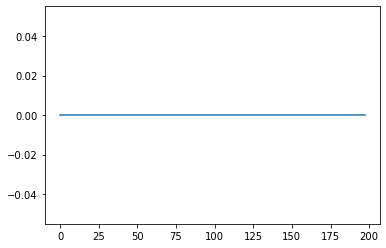

In [4]:
def prod(rho, X, Y):
    P = 1
    for w in zip(X, Y):
        P *= 1 / (2*np.pi * np.sqrt(1-rho*rho))
        P *= np.exp( (w[0]*w[0] - 2*rho*w[0]*w[1] + w[1]*w[1]) / (-2*(1-rho*rho)) )
    return P

def prob(rho, X, Y):
    return pow(1-rho*rho, -3/2)*prod(rho, X, Y)

LL = [prob(i, X, Y) for i in np.arange(-0.99, 0.99, 0.01)]
plt.plot(LL);

In [5]:
max(LL)

0.0

Testamos para vários valores de $-0,99$ a $0,99$ e todos deram $0$.

Vamos agora tentar calcular o logaritmo dessa função: 

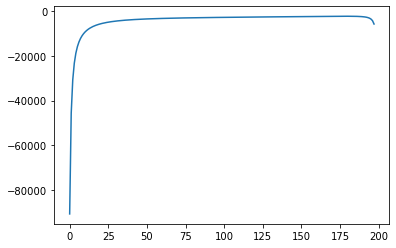

In [6]:
def ln_prod(rho, X, Y):
    n = len(X)
    P = -n * (np.log(2*np.pi) + np.log(1-rho*rho) / 2)
    
    S = 0
    for w in zip(X, Y):
        S += w[0]*w[0] - 2*rho*w[0]*w[1] + w[1]*w[1]
    S /= 2 * (1-rho*rho)
    
    return P - S

def ln_prob(rho, X, Y):
    return -3*np.log(1-rho*rho)/2 + ln_prod(rho, X, Y)

LL = [ln_prod(i, X, Y) for i in np.arange(-0.99, 0.99, 0.01)]
plt.plot(LL);

In [7]:
max(LL)

-2342.9186560166286

Agora sim obtivemos um resultado. Note como o valor até o máximo do logaritmo ainda é um valor
muito baixo, o computador não consegue trabalhar com essa precisão numérica.

Sorte que nosso algoritmo pode usar o $\ln$ da função tranquilamente.

## O algoritmo

Vamos usar o Metropolis–Hastings para gerar a nossa amostra de $\rho$. O algoritmo
vai provocando perturbações aleatórias no valor de $\rho$ e decide se esse novo valor
vai ser aceito ou rejeitado. Usaremos uma uniforme para fazer a perturbação no valor
de $\rho$:

$$\rho \sim \mathcal{U}(\rho^{i-1}-\varepsilon; \rho^{i-1}+\varepsilon)$$

Devemos aceitar ou rejeitar o valor de $\rho$ de uma forma que dê mais peso para
maiores valores de verossimilhança. Para isso calcularemos a razão da verossimilhança
anterior com a nova verossimilhança: 

$$\alpha = \frac{p(\rho^{(i)} ~|~ (X,Y))}{p(\rho^{(i-1)} ~|~ (X,Y))}$$

Se $\alpha$ for maior que 1 eu aceito o candidato a $\rho$, se for entre $0$ e $1$ eu
vou aceitar o candidato com probabilidade $\alpha$.

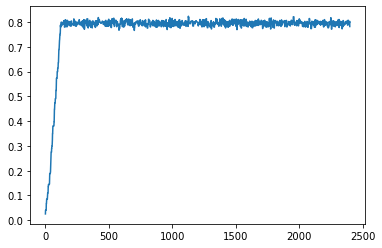

In [8]:
eps = 0.03

rho = 0
all_vals = []

burn = 400
use = 2000

for i in range(burn + use):
    
    # Gera o candidato
    candidate = np.random.uniform(rho-eps, rho+eps)
    
    # Regulariza o valor
    if (candidate < -1):
        candidate = -1+eps
    if (candidate > 1):
        candidate = 1-eps

    # Calcula o alpha
    ln_alpha = ln_prob(candidate, X, Y) - ln_prob(rho, X, Y)
    alpha = np.exp(ln_alpha)
    
    # Calcula o alpha sem usar o ln (não funciona)
    #alpha = prob(candidate, X, Y) / prob(rho, X, Y)

    # Descarta ou aceita o candidato
    u = np.random.uniform(0, 1)
    if (u < alpha):
        rho = candidate
    
    all_vals += [rho]

amostra = all_vals[burn:]
    
plt.plot(all_vals);

Convergiu bem rápido para o valor definido de $0,8$, e descartando os primeiros valores podemos ter uma aproximação da densidade de $\rho$.

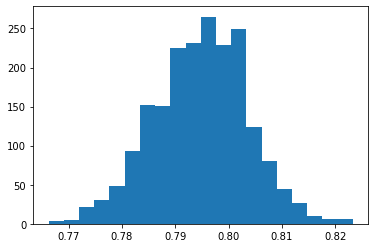

In [9]:
plt.hist(amostra, bins=20);